# work in progress 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people

import shutil
import re
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dropout, Rescaling, Resizing, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, Input, GlobalAveragePooling2D
import tensorflow as tf
from keras import Model

# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import pydot
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import os
import sys

from PIL import Image
import cv2

from sklearn.metrics import classification_report,confusion_matrix

2024-01-05 12:26:21.934055: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 12:26:21.958508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 12:26:22.388385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)

2.13.0


In [3]:
CWD_PATH = os.getcwd()
CWD_FILES = os.listdir(CWD_PATH)
CWD_FILES

['Pneumonia.ipynb',
 'tfobj',
 'my_dir',
 'model.png',
 'chest_xray',
 '.ipynb_checkpoints']

In [4]:
DATA_CLASSES_PATH = os.path.join(CWD_PATH, 'chest_xray')
DATA_CLASSES_FILES = os.listdir(DATA_CLASSES_PATH)
DATA_CLASSES_FILES

['test', 'val', 'train']

In [5]:
DATA_CLASSES_PATH

'/home/aro/wizja/Tensorflow Object Detection/medical/chest_xray'

In [6]:
train_data_path = os.path.join(DATA_CLASSES_PATH, 'train')
test_data_path  = os.path.join(DATA_CLASSES_PATH, 'test')
validation_data_path  = os.path.join(DATA_CLASSES_PATH, 'val')

In [7]:
LABELS = os.listdir(train_data_path)
LABELS

['NORMAL', 'PNEUMONIA']

In [8]:
# def images_couter():
for i in DATA_CLASSES_FILES:
    print("*"*10, 'number of', i.upper(), 'files',"*"*10)
    for j in LABELS:
        print(f"{j}: {len(os.listdir(os.path.join(DATA_CLASSES_PATH,i, j)))}")

********** number of TEST files **********
NORMAL: 234
PNEUMONIA: 390
********** number of VAL files **********
NORMAL: 8
PNEUMONIA: 8
********** number of TRAIN files **********
NORMAL: 1341
PNEUMONIA: 3875


In [9]:
for root, dirs, files in os.walk(train_data_path):
    for name in files:
        image = os.path.join(root, name)
        if 'NORMAL' in train_data_path:
            print('tes')

In [10]:
def dataframe_creator(data_path=None):

    image_size_list = []
    width_list = []
    height_list = []
    name_list = []
    label_list = []
    bacteria = []
    virus = []
    
    is_bacteria = re.compile(r'.*(bacteria).*', re.IGNORECASE)
    is_virus = re.compile(r'.*(virus).*', re.IGNORECASE)
    
    for root, dirs, files in os.walk(data_path):
        for name in files:
            image_path = os.path.join(root, name)
            name_list.append(image_path)
            
            if root.split('/')[-1] == 'NORMAL':
                image_size = round(os.path.getsize(image_path)/ 1000, 2)
                image_size_list.append(image_size)
                label_list.append('NORMAL')
                with Image.open(image_path) as img:
                    width, height = img.size
                    width_list.append(width)
                    height_list.append(height)
                virus.append(0)
                bacteria.append(0)
                
            elif root.split('/')[-1] == 'PNEUMONIA':
                image_size = round(os.path.getsize(image_path) / 1000, 2)
                image_size_list.append(image_size)
                label_list.append('PNEUMONIA')
                with Image.open(image_path) as img:
                    width, height = img.size
                    width_list.append(width)
                    height_list.append(height)
                if bool(is_virus.match(image_path)):
                    virus.append(1)
                    bacteria.append(0)
                elif bool(is_bacteria.match(image_path)):
                    bacteria.append(1)
                    virus.append(0)
                else:
                    virus.append(0)
                    bacteria.append(0)
            
                    
    df = pd.DataFrame({'name': name_list, 'size': image_size_list, 'width': width_list, 
                       'height': height_list, 'class': label_list, 'is_bacteria': bacteria, 'is_virus': virus})
    return df

In [11]:
train_df = dataframe_creator(train_data_path)
test_df = dataframe_creator(test_data_path)
val_df = dataframe_creator(validation_data_path)

In [12]:
train_df.sample(10)

,name,size,width,height,class,is_bacteria,is_virus
8,/home/aro/wizja/Tensorflow Object Detection/me...,829.57,2014,1746,NORMAL,0,0
1817,/home/aro/wizja/Tensorflow Object Detection/me...,104.22,1264,920,PNEUMONIA,1,0
4699,/home/aro/wizja/Tensorflow Object Detection/me...,52.15,904,792,PNEUMONIA,1,0
1307,/home/aro/wizja/Tensorflow Object Detection/me...,1062.84,2138,1928,NORMAL,0,0
947,/home/aro/wizja/Tensorflow Object Detection/me...,354.59,1346,1024,NORMAL,0,0
1622,/home/aro/wizja/Tensorflow Object Detection/me...,92.56,1597,1231,PNEUMONIA,1,0
1295,/home/aro/wizja/Tensorflow Object Detection/me...,764.24,1816,1627,NORMAL,0,0
2620,/home/aro/wizja/Tensorflow Object Detection/me...,64.54,1264,864,PNEUMONIA,1,0
4130,/home/aro/wizja/Tensorflow Object Detection/me...,28.37,912,552,PNEUMONIA,1,0
1643,/home/aro/wizja/Tensorflow Object Detection/me...,64.05,1432,800,PNEUMONIA,1,0


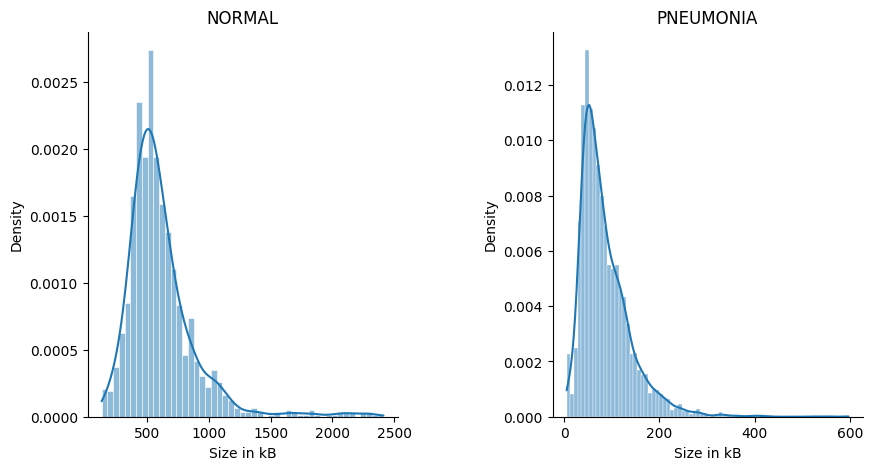

In [13]:
fix, axes = plt.subplots(1, 2, figsize=(10,5))
sns.set_theme(style="ticks", palette="pastel")
plt.subplots_adjust(wspace=0.5)
ax0 = sns.histplot(data=train_df['size'][train_df['class']=='NORMAL'] , fill='True', ax=axes[0], stat='density', kde=True)
ax1 = sns.histplot(data=train_df['size'][train_df['class']=='PNEUMONIA'], fill='True', ax=axes[1], stat='density', kde=True)
ax0.set(xlabel= 'Size in kB', )
ax0.set_title('NORMAL')
ax1.set(xlabel= 'Size in kB')
ax1.set_title('PNEUMONIA')
sns.despine()
plt.show()

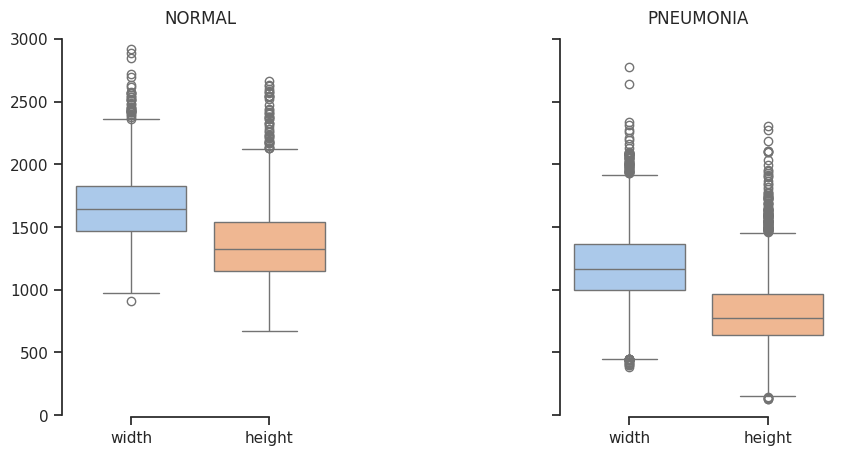

In [14]:
fix, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
# tips = sns.load_dataset(train_df)

# Draw a nested boxplot to show bills by day and time
plt.subplots_adjust(wspace=0.8)
ax0 = sns.boxplot(data=train_df[['width','height']][train_df['class']=='NORMAL'], ax=axes[0])
ax1 = sns.boxplot(data=train_df[['width','height']][train_df['class']=='PNEUMONIA'], ax=axes[1])
ax0.set_title('NORMAL')
ax1.set_title('PNEUMONIA')

sns.despine(trim=True)

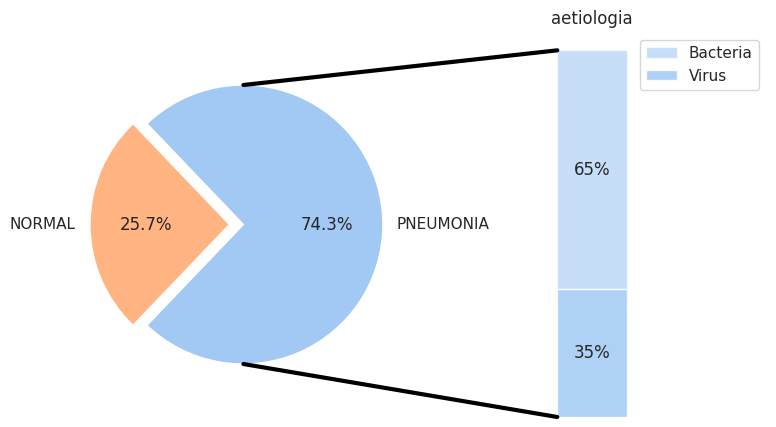

In [15]:
# make figure and assign axis objects
class_normal_ratio = sum(train_df['class']=='NORMAL')/ len(train_df['class'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [1- class_normal_ratio, class_normal_ratio]
labels = ['PNEUMONIA', 'NORMAL']
explode = [0, 0.1]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
aetiologia_ratios = [round(sum(train_df['is_virus']==1)/3875,2), round(sum(train_df['is_bacteria']==1)/3875 ,2)]
aetiologia_labels = ['Virus', 'Bacteria']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(aetiologia_ratios, aetiologia_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label, alpha=0.6 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('aetiologia')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
bar_height = sum(aetiologia_ratios)

# draw top connecting line
x = 0
y = 1
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(3)
ax2.add_artist(con)

# draw bottom connecting line
x = 0
y = -1
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(3)

plt.show()

In [16]:
os.getcwd()

'/home/aro/wizja/Tensorflow Object Detection/medical'

In [17]:
train_df

,name,size,width,height,class,is_bacteria,is_virus
0,/home/aro/wizja/Tensorflow Object Detection/me...,477.62,1554,1353,NORMAL,0,0
1,/home/aro/wizja/Tensorflow Object Detection/me...,568.94,1796,1283,NORMAL,0,0
2,/home/aro/wizja/Tensorflow Object Detection/me...,467.04,1400,1070,NORMAL,0,0
3,/home/aro/wizja/Tensorflow Object Detection/me...,654.49,1620,1480,NORMAL,0,0
4,/home/aro/wizja/Tensorflow Object Detection/me...,465.09,1430,1194,NORMAL,0,0
...,...,...,...,...,...,...,...
5211,/home/aro/wizja/Tensorflow Object Detection/me...,129.64,1344,1032,PNEUMONIA,0,1
5212,/home/aro/wizja/Tensorflow Object Detection/me...,90.37,1122,798,PNEUMONIA,1,0
5213,/home/aro/wizja/Tensorflow Object Detection/me...,38.60,1064,504,PNEUMONIA,1,0
5214,/home/aro/wizja/Tensorflow Object Detection/me...,50.93,791,524,PNEUMONIA,0,1


In [18]:
sum(train_df['is_bacteria']) + sum(train_df['is_virus']) == sum(train_df['class'] == 'PNEUMONIA')

True

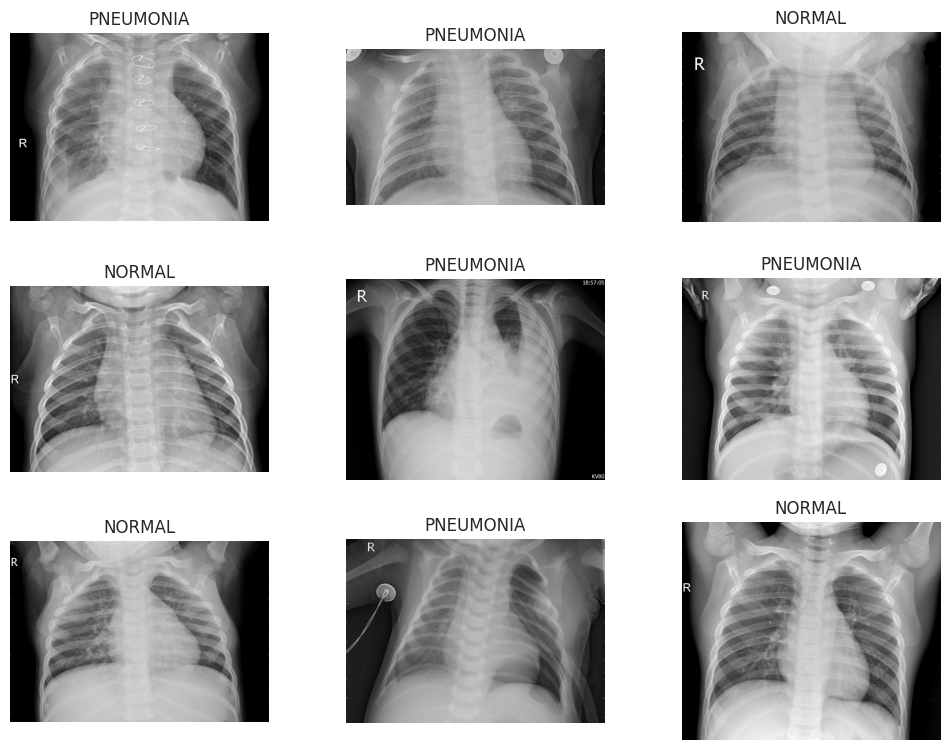

In [19]:
def plot_sample_images(n_rows=3, n_col=3, df = train_df):
    labels = df['class']
    sample = n_rows * n_col
    sample_df = df[['name', 'class']].sample(sample)
    imgs_class = sample_df['class']
    imgs_paths = sample_df['name']
    
    fig , axs = plt.subplots(n_rows, n_col, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=-0.4)
    axs = axs.flatten()
    for img_path, img_class, ax in zip(imgs_paths,imgs_class, axs):
        image = Image.open(img_path)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{img_class}')
    plt.show()
    
plot_sample_images(df = train_df)

In [20]:
DATA_CLASSES_PATH

'/home/aro/wizja/Tensorflow Object Detection/medical/chest_xray'

In [21]:
cv2.imread(train_df['name'][5])

array([[[  1,   1,   1],
        [101, 101, 101],
        [ 98,  98,  98],
        ...,
        [ 86,  86,  86],
        [ 77,  77,  77],
        [ 74,  74,  74]],

       [[  0,   0,   0],
        [106, 106, 106],
        [100, 100, 100],
        ...,
        [ 78,  78,  78],
        [ 70,  70,  70],
        [ 69,  69,  69]],

       [[  0,   0,   0],
        [110, 110, 110],
        [101, 101, 101],
        ...,
        [ 72,  72,  72],
        [ 69,  69,  69],
        [ 69,  69,  69]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [22]:
h, w = 224, 224

In [23]:
# resize_rescale = Sequential([
#     Resizing(h,w),
#     Rescaling(1.0/255)])

In [24]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape = (h, w, 3)),
    RandomRotation(0.10),
    RandomContrast(0.15),
    RandomBrightness(0.15)])

2024-01-05 12:26:24.698910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-05 12:26:24.713233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-05 12:26:24.713355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [25]:
batch_size = 64

train_ds = image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
    seed=123,
  image_size=(h, w),
  batch_size=batch_size
)

val_ds = image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="validation",
    seed=123,
  image_size=(h, w),
  batch_size=batch_size
)

test_ds = image_dataset_from_directory(
  test_data_path,
  image_size=(h, w),
        seed=123,
  batch_size=batch_size,
    shuffle=False)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


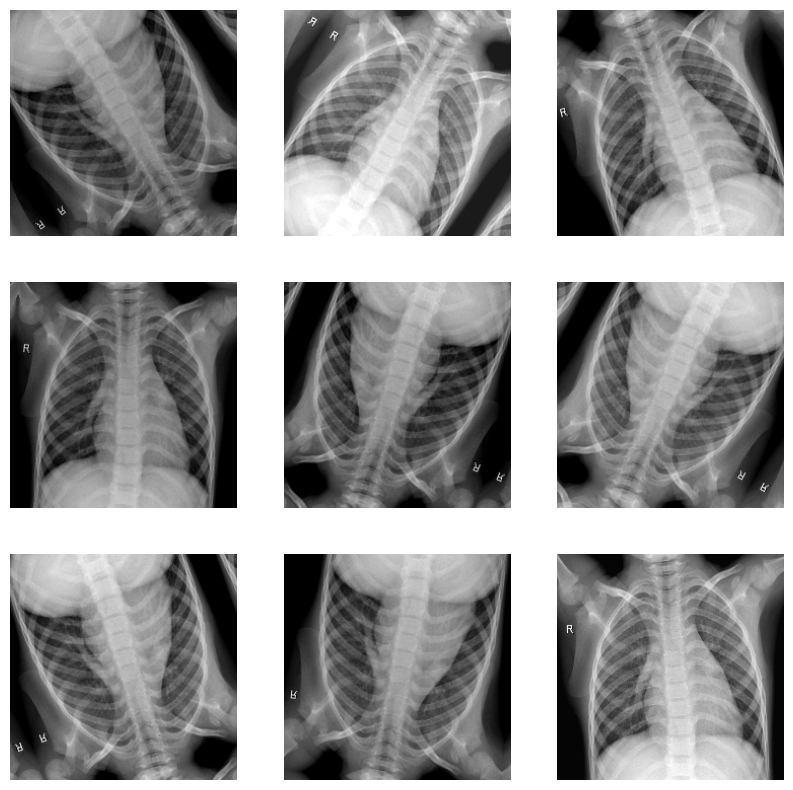

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


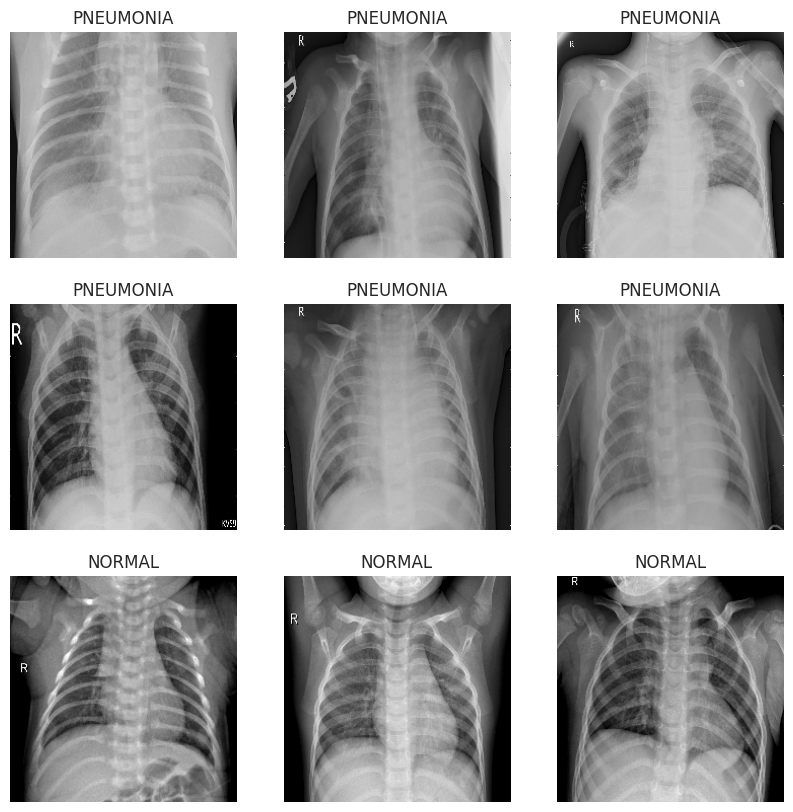

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [30]:
normalization_layer = Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
model_custom = Sequential([
data_augmentation,
Rescaling(1./255,),
Conv2D(64, (3,3), activation='relu', input_shape = (h, w, 3)),
MaxPool2D(2,2),
    
Conv2D(128, (3,3), activation='relu'),
MaxPool2D(2,2),
Dropout(0.4),

Conv2D(64, (3,3), activation='relu'),
MaxPool2D(2,2),
Dropout(0.4),

Conv2D(64, (3,3), activation='relu'),
MaxPool2D(2,2),
Dropout(0.4),

Flatten(),
Dense(64, activation='relu'),
Dropout(0.3),
Dense(1, activation='sigmoid')
])

In [37]:
model_custom.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=False)

# model.summary()


In [38]:
history_custom_model = model_custom.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/20


2024-01-05 12:26:53.141138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - 16s 230ms/step - loss: 0.5975 - accuracy: 0.7292 - val_loss: 0.5125 - val_accuracy: 0.7766
Epoch 2/20
66/66 [==============================] - 13s 197ms/step - loss: 0.4739 - accuracy: 0.7702 - val_loss: 0.3817 - val_accuracy: 0.8274
Epoch 3/20
66/66 [==============================] - 13s 194ms/step - loss: 0.4256 - accuracy: 0.7755 - val_loss: 0.3682 - val_accuracy: 0.8648
Epoch 4/20
66/66 [==============================] - 13s 195ms/step - loss: 0.3509 - accuracy: 0.8406 - val_loss: 0.2948 - val_accuracy: 0.8974
Epoch 5/20
66/66 [==============================] - 13s 195ms/step - loss: 0.3393 - accuracy: 0.8533 - val_loss: 0.3402 - val_accuracy: 0.9080
Epoch 6/20
66/66 [==============================] - 13s 195ms/step - loss: 0.3069 - accuracy: 0.8627 - val_loss: 0.2729 - val_accuracy: 0.9032
Epoch 7/20
66/66 [==============================] - 13s 194ms/step - loss: 0.3370 - accuracy: 0.8541 - val_loss: 0.2569 - val_accuracy: 0.9022
Epoch 8/20

In [40]:
def model_evaluate(model, dataset=test_ds ):
    loss, accuracy = model.evaluate(dataset, verbose = 0)
    print('Test dataset score:')
    print("loss : {:9.2f}".format(loss))
    print("accuracy : {:5.2f}%".format(100 * accuracy))

In [41]:
model_evaluate(model_custom)

Test dataset score:
loss :      0.46
accuracy : 86.70%


In [42]:
def result_plotter(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

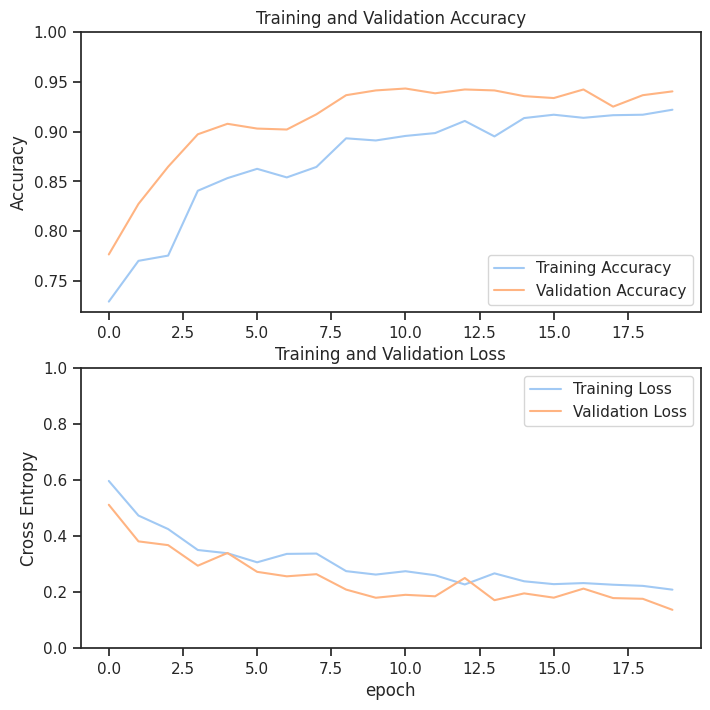

In [43]:
result_plotter(history_custom_model)

In [44]:
def confusion_matrix_plotter(model, database):
    
    y_true = np.concatenate([y for x, y in database], axis=0)
    predictions = model.predict(database, steps=len(database), verbose=0)
    y_pred = np.round(predictions)
    # report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])
    confs_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(confs_matrix, annot = True, fmt='d', cmap='crest', xticklabels=['Normal', 'Pneumonia'], 
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return y_true, y_pred

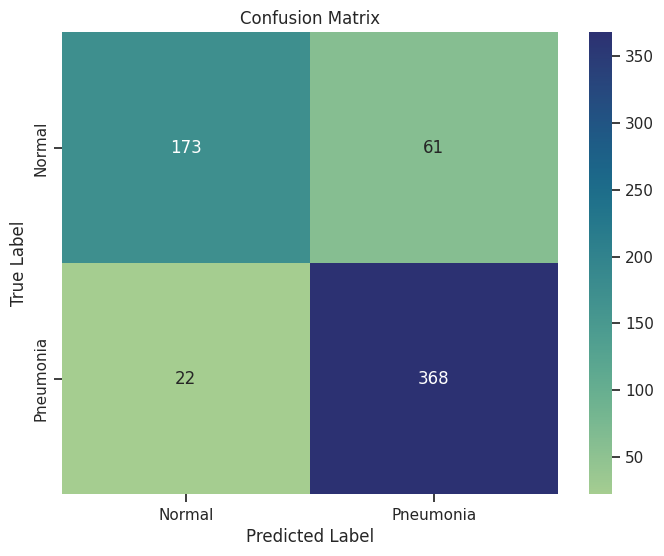

In [45]:
y_true, y_pred = confusion_matrix_plotter(model_custom, test_ds)

In [46]:
print(classification_report(y_true, y_pred, target_names=['normal', 'pneumonia']))

              precision    recall  f1-score   support

      normal       0.89      0.74      0.81       234
   pneumonia       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



# transfer learning

In [47]:
base_model = ResNet152V2(
    weights='imagenet',
    input_shape=(h, w, 3),
    include_top=False)

In [48]:
base_model.trainable = False

In [49]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [50]:
def model_func():

    inputs = tf.keras.Input(shape=(h, w, 3))
    
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    return model

In [51]:
model_pretrained = model_func()

In [52]:
model_pretrained.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=False)

In [53]:
model_pretrained.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 sequential (Sequential)     (None, 224, 224, 3)       0         Y          
                                                                            
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         Y          
 a)                                                                         
                                                                            
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         Y          
 da)                                                                        
                                                                            
 resnet152v2 (Functional)    (None, 7, 7, 2048)        583316

In [54]:
history_pretrained = model_pretrained.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/10
66/66 [==============================] - 32s 413ms/step - loss: 0.2503 - accuracy: 0.9008 - val_loss: 0.1226 - val_accuracy: 0.9530
Epoch 2/10
66/66 [==============================] - 25s 384ms/step - loss: 0.1567 - accuracy: 0.9410 - val_loss: 0.1049 - val_accuracy: 0.9607
Epoch 3/10
66/66 [==============================] - 25s 384ms/step - loss: 0.1348 - accuracy: 0.9475 - val_loss: 0.0922 - val_accuracy: 0.9655
Epoch 4/10
66/66 [==============================] - 25s 384ms/step - loss: 0.1299 - accuracy: 0.9502 - val_loss: 0.0910 - val_accuracy: 0.9664
Epoch 5/10
66/66 [==============================] - 25s 385ms/step - loss: 0.1260 - accuracy: 0.9514 - val_loss: 0.0842 - val_accuracy: 0.9684
Epoch 6/10
66/66 [==============================] - 25s 385ms/step - loss: 0.1210 - accuracy: 0.9576 - val_loss: 0.0831 - val_accuracy: 0.9712
Epoch 7/10
66/66 [==============================] - 25s 385ms/step - loss: 0.1025 - accuracy: 0.9605 - val_loss: 0.0983 - val_accuracy: 0.9588

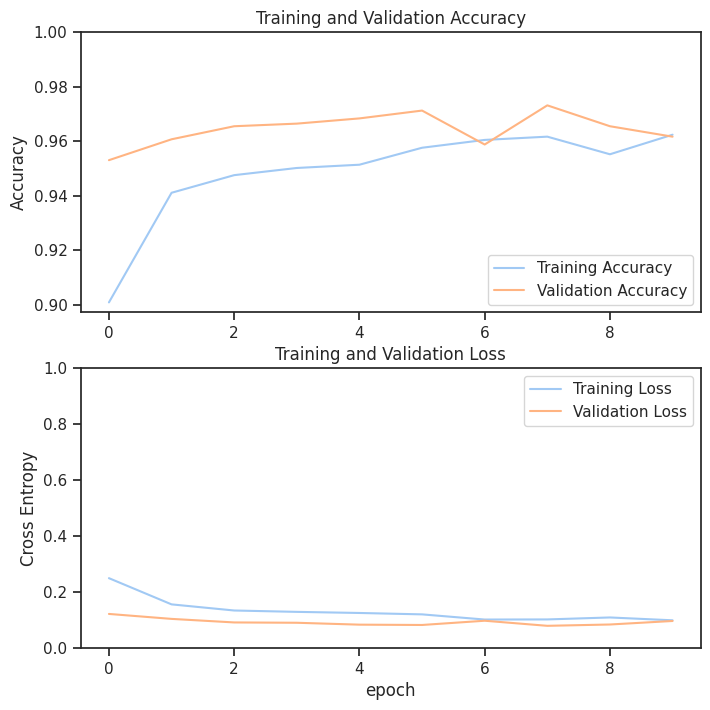

In [55]:
result_plotter(history_pretrained)

In [56]:
model_pretrained.evaluate(test_ds)

10/10 [==============================] - 4s 408ms/step - loss: 0.8025 - accuracy: 0.7596


[0.8024541735649109, 0.7596153616905212]

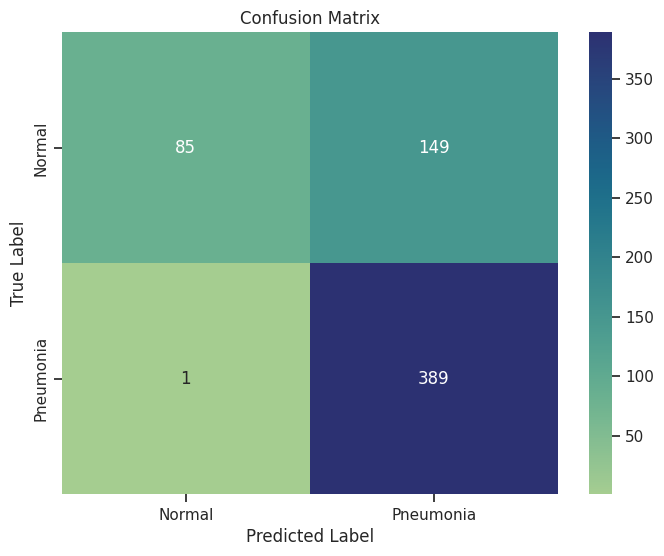

In [57]:
y_true, y_pred = confusion_matrix_plotter(model_pretrained, test_ds)

# Fine tuning

In [58]:
base_model.name

'resnet152v2'

In [59]:
len(base_model.layers)

564

In [60]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [61]:
base_model.trainable = True

In [62]:
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [63]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [64]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [65]:
model_fine_tuned = model_func()

In [66]:
model_fine_tuned.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=False)

In [67]:
model_fine_tuned.summary(show_trainable=True)


Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 sequential (Sequential)     (None, 224, 224, 3)       0         Y          
                                                                            
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         Y          
 bda)                                                                       
                                                                            
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         Y          
 mbda)                                                                      
                                                                            
 resnet152v2 (Functional)    (None, 7, 7, 2048)        5833

In [68]:
history_tuned = model_fine_tuned.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/10
66/66 [==============================] - 37s 447ms/step - loss: 0.2548 - accuracy: 0.8970 - val_loss: 0.1659 - val_accuracy: 0.9319
Epoch 2/10
66/66 [==============================] - 27s 416ms/step - loss: 0.1268 - accuracy: 0.9521 - val_loss: 0.1017 - val_accuracy: 0.9703
Epoch 3/10
66/66 [==============================] - 27s 413ms/step - loss: 0.1009 - accuracy: 0.9607 - val_loss: 0.0757 - val_accuracy: 0.9770
Epoch 4/10
66/66 [==============================] - 27s 414ms/step - loss: 0.0785 - accuracy: 0.9700 - val_loss: 0.0742 - val_accuracy: 0.9751
Epoch 5/10
66/66 [==============================] - 27s 414ms/step - loss: 0.0782 - accuracy: 0.9698 - val_loss: 0.0763 - val_accuracy: 0.9770
Epoch 6/10
66/66 [==============================] - 27s 414ms/step - loss: 0.0860 - accuracy: 0.9669 - val_loss: 0.0690 - val_accuracy: 0.9799
Epoch 7/10
66/66 [==============================] - 27s 413ms/step - loss: 0.0589 - accuracy: 0.9775 - val_loss: 0.0838 - val_accuracy: 0.9732

In [69]:
model_fine_tuned.evaluate(test_ds)

10/10 [==============================] - 3s 294ms/step - loss: 0.6100 - accuracy: 0.8654


[0.6099915504455566, 0.8653846383094788]

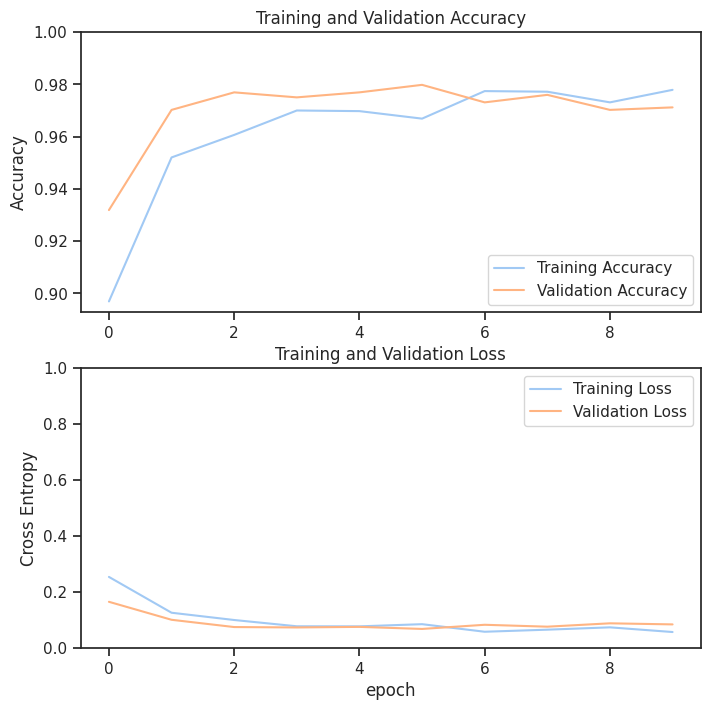

In [70]:
result_plotter(history_tuned)

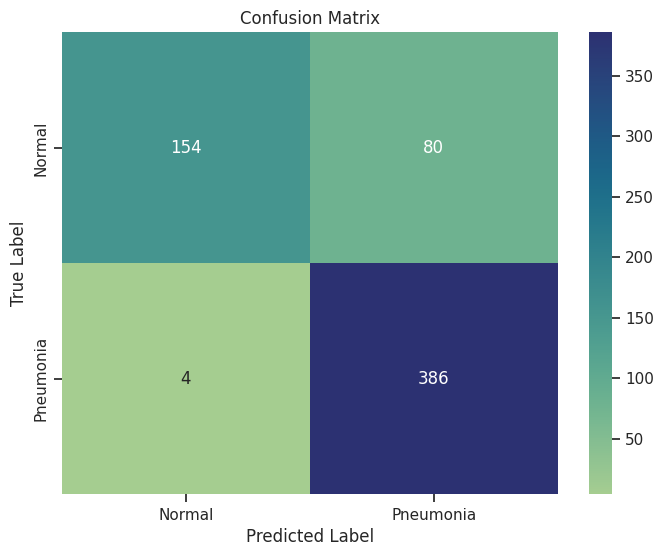

In [71]:
y_true, y_pred = confusion_matrix_plotter(model_fine_tuned, test_ds)